# Using Neural Networks for a Regression Problem

This notebooks demonstrates how to use neural networks to solve a regression problem using Python.  The specific issues is the determination of corporations' effective tax rate (ETR) based on various financial and operational features.  This example is based on the work of [Belnap, Kroeger, and Thornock (2023), "Explaining Tax Avoidance: Insights from Thirty Years of Research"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4530437).

In [16]:
# %%
import copy
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score
# from torchmetrics.regression import R2Score
import tqdm
from sklearn.model_selection import train_test_split
import os


In [12]:
CUR_DIR = os.getcwd()

# %%
# Choose sample to use
dep_var = "Cash ETR"

# Read data
df = pd.read_csv(os.path.join(CUR_DIR, "ETR_sample.csv"))


# %%
# Drop obs if missing any of indep or dep vars
THEORY_VARS = [
    # "Stock Compensation Mix",
    "Male_CEO",
    "Manager Ability",
    "Size",
    "Earnings Announcement Speed",
    "RankChangeZ",
    "RankChangeKZ",
    "NoDividends",
    "JunkRating",
    "R&D",
    "Intangible Intensity",
    "Foreign Income",
    "MNC",
    "BTM",
    "Capital Intensity",
    "ROA",
    "NOL",
    "Leverage",
    "fyear",
    "industry",
    "state",
]
indep_vars = THEORY_VARS
df = df[[dep_var] + indep_vars]
df.dropna(inplace=True)

/var/folders/bw/1cvntf9x02b49nfwgy_qnfn00000gp/T/ipykernel_78264/2943328671.py:8: DtypeWarning: Columns (11,27,31,34,35,36,946,947,949,956,971,989,990) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(CUR_DIR, "ETR_sample.csv"))


In [13]:
# %%
# Select data objects for NN
# One-hot encode the data using pandas get_dummies
# df = pd.get_dummies(df, columns=["fyear", "state", "industry"])
df.drop(columns=["fyear", "state", "industry"], inplace=True)
y = df[dep_var].values
X = df.loc[:, df.columns != dep_var].values
indep_vars = df.loc[:, df.columns != dep_var].columns.tolist()
num_vars = X.shape[1]


# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True
)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.astype(np.float64), dtype=torch.float32)
y_train = torch.tensor(y_train.astype(np.float64), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.astype(np.float64), dtype=torch.float32)
y_test = torch.tensor(y_test.astype(np.float64), dtype=torch.float32).reshape(-1, 1)


In [14]:
# Define the model
# Here using a pyramid structure
model = nn.Sequential(
    nn.Linear(num_vars, num_vars * 10),
    nn.ReLU(),
    nn.Linear(num_vars * 10, num_vars * 10),
    nn.ReLU(),
    nn.ReLU(),
    nn.ReLU(),
    nn.Linear(num_vars * 10, 24),
    nn.ReLU(),
    nn.ReLU(),
    nn.ReLU(),
    nn.ReLU(),
    nn.Linear(24, 1),  # Might change this last layer if we think ETR (or UTB) bounded
    # nn.Softmax(),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0005)


n_epochs = 2000  # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history_mse = []
history_r2 = []

/var/folders/bw/1cvntf9x02b49nfwgy_qnfn00000gp/T/ipykernel_78264/3401155178.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  bar.set_postfix(mse=float(loss))


Finished epoch 0, latest loss 0.039509568363428116
Finished epoch 1, latest loss 0.035864848643541336
Finished epoch 2, latest loss 0.03587040677666664
Finished epoch 3, latest loss 0.03515943884849548
Finished epoch 4, latest loss 0.03497394546866417
Finished epoch 5, latest loss 0.03477137163281441
Finished epoch 6, latest loss 0.0345042459666729
Finished epoch 7, latest loss 0.03430461883544922
Finished epoch 8, latest loss 0.03398619219660759
Finished epoch 9, latest loss 0.03396540507674217
Finished epoch 10, latest loss 0.03362410515546799
Finished epoch 11, latest loss 0.033695753663778305
Finished epoch 12, latest loss 0.03312762454152107
Finished epoch 13, latest loss 0.03311781585216522
Finished epoch 14, latest loss 0.03270123153924942
Finished epoch 15, latest loss 0.03281222656369209
Finished epoch 16, latest loss 0.032406654208898544
Finished epoch 17, latest loss 0.03238728642463684
Finished epoch 18, latest loss 0.0320083387196064
Finished epoch 19, latest loss 0.031840

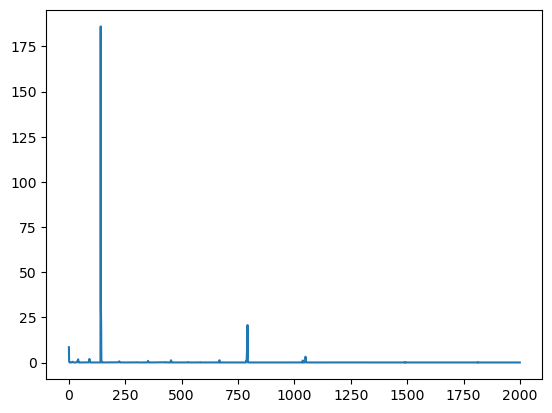

In [17]:
# Training loops
for epoch in range(n_epochs):
    model.train() # set model to training mode
    with tqdm.tqdm(
        batch_start, unit="batch", mininterval=0, disable=True
    ) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()  # set model to evaluation mode
    # y_pred = model(X_test)
    y_pred = model(X_train)
    # mse = loss_fn(y_pred, y_test)
    mse = loss_fn(y_pred, y_train)
    mse = float(mse)
    r2score = R2Score()
    # r2score.update(y_pred, y_test)
    r2score.update(y_pred, y_train)
    r2 = float(r2score.compute())
    history_mse.append(mse)
    history_r2.append(r2)
    print(f'Finished epoch {epoch}, latest loss {loss}')
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.4f" % best_mse)
print("RMSE: %.4f" % np.sqrt(best_mse))
print("R2: %.4f" % best_r2)
# history_mse = np.array(history_mse)
# history_mse[history_mse > 0.04] = 0.04
plt.plot(history_mse)
plt.show()


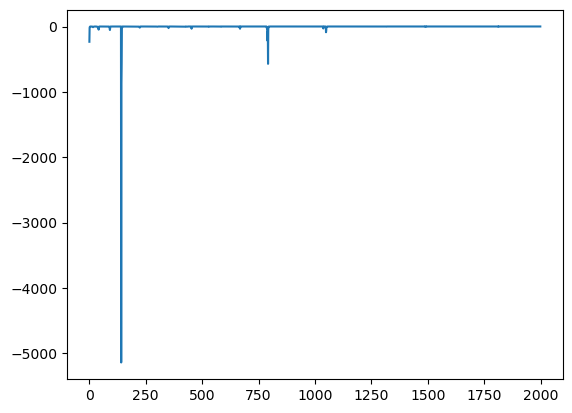

In [18]:
plt.plot(history_r2)
plt.show()

In [19]:
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False), :]
y_sample = y_train[np.random.choice(y_train.shape[0], 1000, replace=False)]


In [ ]:
explainer = shap.DeepExplainer(
    model,
    data=background,#.astype(np.float64),
    # feature_pertubation="independence",
    # model_output="logloss",
    # model_output="score",
)
# shap_values = explainer(X_train, y_train)
shap_values = explainer.shap_values(X_train)
feature_names = df.loc[:, df.columns != dep_var].columns.tolist()
fig = plt.gcf()
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
fig.show()


In [ ]:
fig2 = plt.gcf()
shap.plots.bar(shap_values, show=False)
fig2.show()

0        1.0
1        0.0
2        1.0
3        0.0
4        0.0
        ... 
16545    0.0
16546    1.0
16547    1.0
16548    1.0
16549    1.0
Name: Male_CEO, Length: 16550, dtype: float64